In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import desc

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector=inspect(engine)
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
inspector=inspect(engine)
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Meas = Base.classes.measurement
Sta = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(Meas.date).order_by(Meas.date.desc()).first()

('2017-08-23')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago
# print(year_ago)

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
# only collecting date and prcp
wdata = session.query(Meas.date, Meas.prcp).\
                filter(Meas.date.between ("2016-08-23", "2017-08-23")).all()
# wdata

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
wdata_df = pd.DataFrame(wdata, columns=["Date", "Precipitation"])
wdata_df.set_index("Date", inplace = True)
wdata_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# Sort the dataframe by date
sorted_df = wdata_df.sort_index()
sorted_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


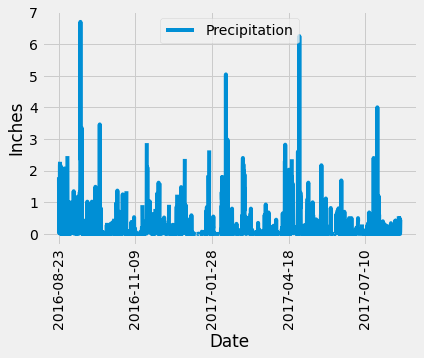

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = sorted_df.plot(rot = 90)

plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig("ty_HW10_precip_line.png",bbox_inches='tight')

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
wdata_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
sta_count = session.query(func.count(Sta.name)).all()
sta_count

[(9)]

In [19]:
sta_names = session.query(Sta.name).all()
sta_names

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_sta = session.query(Meas.station,func.count(Meas.station)).\
             group_by(Meas.station).\
             order_by(desc(func.count(Meas.station))).all()
active_sta

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active_sta_temps = session.query(func.min(Meas.tobs), func.max(Meas.tobs), func.avg(Meas.tobs)).\
             filter(Meas.station == 'USC00519281').all()
active_sta_temps

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# most recent date for most active station

session.query(Meas.date).\
filter(Meas.station == 'USC00519281').\
order_by(Meas.date.desc()).first()

('2017-08-18')

In [23]:
#collect data to plot histogram for last 12 months from most recent date for station
act_sta_data = session.query(Meas.tobs).\
               filter(Meas.station == 'USC00519281').\
               filter(Meas.date.between ("2016-08-18", "2017-08-18")).all()
# act_sta_data

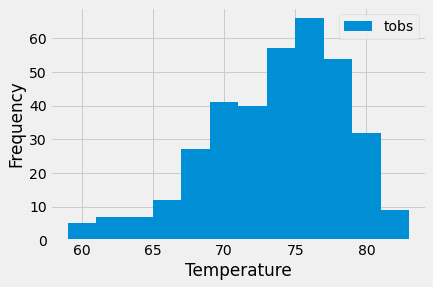

In [24]:
# Plot data as histogram

act_sta_data_df = pd.DataFrame(act_sta_data, columns=["tobs"])
# act_sta_data_df.head()
act_sta_data_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.savefig("ty_HW10_temp_hist.png",bbox_inches='tight')

# Close session

In [25]:
# Close Session
session.close()